In [105]:
import numpy as np
import torch
import pandas as pd
from kan import *
from collections import deque
!pip install ucimlrepo  --quiet

In [106]:
from ucimlrepo import fetch_ucirepo

# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets
# metadata 
metadata = predict_students_dropout_and_academic_success.metadata

# variable information 
variable_info = predict_students_dropout_and_academic_success.variables

df = X
df['Target'] = y

print(f"{df.shape[0]} entries with {df.shape[1]} features")

4424 entries with 37 features


In [107]:
categorical_vars = {
    'Marital Status',
    'Application mode',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    'Mother\'s qualification',
    'Father\'s qualification',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'International',
    'Target'
}
quantitative_vars = {
   'Application order',
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
   'Curricular units 1st sem (enrolled)',
   'Curricular units 1st sem (credited)',
   'Curricular units 1st sem (evaluations)',
   'Curricular units 1st sem (approved)',
   'Curricular units 1st sem (grade)',
   'Curricular units 1st sem (without evaluations)',
   'Curricular units 2nd sem (credited)',
   'Curricular units 2nd sem (enrolled)',
   'Curricular units 2nd sem (evaluations)',
   'Curricular units 2nd sem (approved)',
   'Curricular units 2nd sem (grade)',
   'Curricular units 2nd sem (without evaluations)',
   'Unemployment rate',
   'Inflation rate',
    'GDP'
}
print("categorical vars", len(categorical_vars))
print("quantitative vars", len(quantitative_vars))
#print(df.columns)

categorical vars 18
quantitative vars 19


In [108]:
# remove the 'enrolled' column from dataframe:
df.drop(['Inflation rate', 'GDP'], axis=1, inplace=True)
misc_curriculum = [
    "Curricular units 1st sem (evaluations)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 1st sem (credited)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (without evaluations)",
]
quantitative_vars -= set(misc_curriculum).union({"Inflation rate", "GDP"})
df.drop(misc_curriculum, axis=1, inplace=True)

df_encoded = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
df_encoded["Target"] = df_encoded["Target"].replace({'Graduate': 0, 'Dropout': 1})
# Applying one-hot encoding on categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=list(categorical_vars - {'Target'}))

# normalize quantitative columns:
df_encoded[list(quantitative_vars)] = df_encoded[list(quantitative_vars)].apply(lambda x: (x-x.min())/(x.max()-x.min()))

valid_count = int(len(df_encoded) * 0.7)
test_count = int(len(df_encoded) * 0.8)
df_shuffled = df_encoded.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_encoded[:valid_count].reset_index(drop=True)
df_valid = df_encoded[valid_count:test_count].reset_index(drop=True)
df_test = df_encoded[test_count:].reset_index(drop=True)

y_train = df_train["Target"]
x_train = df_train.drop(["Target"], axis=1)
y_test = df_test["Target"]
x_test = df_test.drop(["Target"], axis=1)
y_valid = df_valid["Target"]
x_valid = df_valid.drop(["Target"], axis=1)


In [109]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [118]:
def prep_dataset(x_train, y_train, x_valid, y_valid, x_test, y_test):
    
    def get_dataloader(x, y, shuffle=False, batch_size=1):
        x, y = x.to_numpy().astype(np.float32), y.to_numpy().astype(np.int32)
        x = torch.from_numpy(x).to(torch.float32)
        y = torch.from_numpy(y).to(torch.long)
        ds = torch.utils.data.TensorDataset(x,y)
        return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=shuffle) 
    def get_ds_tensors(loader):
        x = torch.empty(0, x_train.shape[1], device=device)
        y = torch.empty(0, dtype=torch.long, device=device)
        for data, labels in loader:
            x = torch.cat((x, data.to(device)), dim=0)
            y = torch.cat((y, labels.to(device)), dim=0)
        return x, y
    
    x_train, y_train = get_ds_tensors(get_dataloader(x_train, y_train, shuffle=True))
    x_valid, y_valid = get_ds_tensors(get_dataloader(x_valid, y_valid, shuffle=False))
    x_test, y_test = get_ds_tensors(get_dataloader(x_test, y_test, shuffle=False))
    
    train_ds = {}
    train_ds['train_input'] = x_train
    train_ds['test_input'] = x_valid 
    train_ds['train_label'] = y_train
    train_ds['test_label'] = y_valid
    test_ds = {}
    test_ds['test_input'] = x_test
    test_ds['test_label'] = y_test
    
    return train_ds, test_ds

train_ds, test_ds = prep_dataset(x_train, y_train, x_valid, y_valid, x_test, y_test)

In [119]:
model = KAN(width=[238, 2, 2], grid=5, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


In [120]:
image_folder = "/Users/alexiy/Projects/Purdue/cs573_proj/kan_img"

In [132]:
all_train_acc = []
all_valid_acc = []
def train_acc():
    train_acc = torch.mean((torch.argmax(model(train_ds['train_input']), dim=1) == train_ds['train_label']).float())
    all_train_acc.append(train_acc.item())
    return train_acc

def test_acc():
    valid_acc = torch.mean((torch.argmax(model(test_ds['test_input']), dim=1) == test_ds['test_label']).float())
    all_valid_acc.append(valid_acc.item())
    return valid_acc

results = model.fit(train_ds, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=100, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder=image_folder)


description:   0%|                                                          | 0/100 [04:25<?, ?it/s]

| train_loss: 8.39e-01 | test_loss: 8.28e-01 | reg: 2.83e+02 | :   1%| | 1/100 [00:32<54:05, 32.78s/
| train_loss: 8.38e-01 | test_loss: 8.36e-01 | reg: 3.83e+02 | :   1%| | 1/100 [00:32<54:05, 32.78s/
| train_loss: 8.38e-01 | test_loss: 8.36e-01 | reg: 3.83e+02 | :   2%| | 2/100 [01:04<52:55, 32.40s/
| train_loss: 8.34e-01 | test_loss: 1.06e+00 | reg: 4.65e+02 | :   2%| | 2/100 [01:05<52:55, 32.40s/
| train_loss: 8.34e-01 | test_loss: 1.06e+00 | reg: 4.65e+02 | :   3%| | 3/100 [01:36<51:59, 32.16s/
| train_loss: 1.05e+00 | test_loss: 8.33e-01 | reg: 4.00e+02 | :   3%| | 3/100 [01:36<51:59, 32.16s/
| train_loss: 1.05e+00 | test_loss: 8.33e-01 | reg: 4.00e+02 | :   4%| | 4/100 [02:10<52:07, 32.58s/
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 3.88e+02 | :   4%| | 4/100 [02:10<52:07, 32.58s/
| train_loss: 8.33e-01 | test_loss: 8.33e-01 | reg: 3.88e+02 | :   5%| | 5/100 [02:42<51:

saving model version 0.1


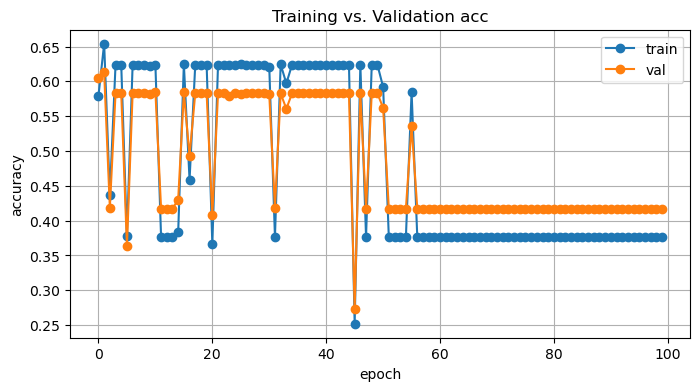

In [136]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(range(len(all_train_acc)), all_train_acc, marker='o', label='train')
plt.plot(range(len(all_valid_acc)), all_valid_acc, marker='o', label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training vs. Validation acc')
plt.grid(True)
plt.legend()
plt.show()